Choose one of the classifiers below, more information on how they work is at this [link](https://scikit-learn.org/stable/supervised_learning.html). Find out what parameters can be tuned for each of the classififers and using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), create the best classifier you can.


In [1]:
#Numeric Library
import numpy as np
import pandas as pd

#Pipeline Libraries
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit
from sklearn.feature_selection import RFE
import sklearn.preprocessing as skpp

#classifier Libraries
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.neural_network import MLPClassifier

#Ploting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

def normalize(data,data_min,data_max): 
    # scale all feature values to range [0,1]
    return (data - data_min)/(data_max - data_min)

def make_plot(data_t, y_t, best_clf, clf_name, clf_flag, score):
    """Make colormap.
    Parameters
    ----------
    data_t : pandas.DataFrame, numpy.ndarray
        Dataset to plot.
    y_t : numpy.ndarray
        Data labels.
    best_clf : sklearn.Classifier
        Classifier.
    clf_name : str
        Classifier name to be printed on plot title.
    clf_flag : str
        Feature classificiation???
    score : float
        Classifier score in percent.
    Returns
    -------
    ax : matplotlib.Axes
        Axes handle
    """
    fsz = 20
    # Update rcParams with the necessary values
    plt.rc('font', size=fsz)  # controls default text sizes
    plt.rc('axes', titlesize=fsz)  # fontsize of the axes title
    plt.rc('axes', labelsize=fsz)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=fsz - 2)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=fsz - 2)  # fontsize of the tick labels
    fig, ax = plt.subplots(1,1, figsize=(16,10))
    # Make a scatterplot of the dataset
    ax.scatter(
        data_t[:,0],
        data_t[:,1],
        c = y_t,
        s = 20,
        zorder=10, 
        edgecolors='black')
    #
    xx,yy = np.meshgrid(
        np.linspace(data_t[:,0].min(),data_t[:,0].max(), 100),
        np.linspace(data_t[:,1].min(),data_t[:,1].max(), 100))
    p = best_clf.predict(np.stack([xx.ravel(),yy.ravel()]).T)
    # plt.contourf(xx,yy,p.reshape(xx.shape),alpha=.7,levels=[-1,0,1,2],cmap='coolwarm')
    clr_map = ax.contourf(xx,yy,p.reshape(xx.shape),alpha=.7,cmap='viridis')
    # Make colorbar
    cbar = plt.colorbar(clr_map, ax=ax)
    cbar.ax.tick_params(labelsize= 18)
    # 
    if clf_flag == 'PCA':
        ax_kwargs = {'title' : "{} classifier (PCA | {:.4f})".format(clf_name.upper(), score ),
                     'xlabel': "PCA 1", 
                     'ylabel': "PCA 2"}
        figname='{}_pca2.png'.format(clf_name.lower() ) 
    elif clf_flag == 'RFE':
        ax_kwargs = {'title' : "{} classifier (RFE | {:.4f})".format(clf_name.upper(), score ),
                     'xlabel': RFE1name, 
                     'ylabel': RFE2name}
        figname='{}_rfe2.png'.format(clf_name.lower() )
    ax.set( **ax_kwargs)
    fig.savefig(figname)
    return ax

# Gather Meta Data for Downsampling Lopsided Class

In [2]:
# Load Data
po_wine_r = pd.read_csv('./Portuguese/red.csv')
po_wine_w = pd.read_csv('./Portuguese/white.csv')

# Clean Data
po_wine_r = po_wine_r.drop('Unnamed: 0',axis=1)
po_wine_w = po_wine_w.drop('Unnamed: 0',axis=1)

# Collect Metadata
[r_size, Nfeat] = np.shape(po_wine_r)
[w_size, Nfeat] = np.shape(po_wine_w)
print("Ndat %d | r_size = %d | w_size = %d" % (r_size + w_size, r_size, w_size))

# Downsample majority class
df_majority=po_wine_w
df_minority=po_wine_r

# Do only one down sample to get a fixed data set. 
majority_downsampled = resample(df_majority, 
                                replace=False,    # sample without replacement
                                n_samples=r_size, # to match minority class
                                random_state=9653454
                               )  # reproducible results
po_wine = pd.concat([majority_downsampled, df_minority])

Ndat 6497 | r_size = 1599 | w_size = 4898


# Determine Best Features to CLF With RFE

In [9]:
score = dict()
for name in po_wine_r.columns:
    score[name]=0
    
N=100 # number of Down samples to attempt!
#This part of code takes a bit to 
for i in range(N):
    seed = np.random.randint(1235123,9182374)
    majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=r_size, # to match minority class
                                 random_state=seed) # reproducible results
    po_wine = pd.concat([majority_downsampled, df_minority])
    #Collect labels and locations
    y = po_wine.loc[ : , po_wine.columns == 'type'] 
    y=y.replace('red',0) 
    y=y.replace('white',1)
    y=np.array(y)

    # Split Data and Normalize!
    data = np.array(po_wine.drop('type', axis = 1) )
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=13498573)
    X_train_min = X_train.min(axis=0)
    X_train_max = X_train.max(axis=0)
    X_train = normalize(X_train,X_train_min,X_train_max)
    X_test  = normalize(X_test,X_train_min,X_train_max)
    
    # Recursive Feature Elimination Ranking
    svc = svm.SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=2, step=1)
    rfe_fit=rfe.fit(X_train, y_train.ravel())
    ranking=rfe.ranking_

    bestpos=np.where(ranking == ranking.min())
    RFE1name=po_wine.columns[bestpos][0]
    RFE2name=po_wine.columns[bestpos][1]
    score[RFE1name] += 1  
    score[RFE2name] += 1 


print(score)

{'fixed acidity': 0, 'volatile acidity': 62, 'citric acid': 0, 'residual sugar': 4, 'chlorides': 9, 'free sulfur dioxide': 0, 'total sulfur dioxide': 81, 'density': 42, 'pH': 0, 'sulphates': 2, 'alcohol': 0, 'quality': 0, 'type': 0}


# Exploratory Data Analysis

Text(0, 0.5, 'volatile acidity')

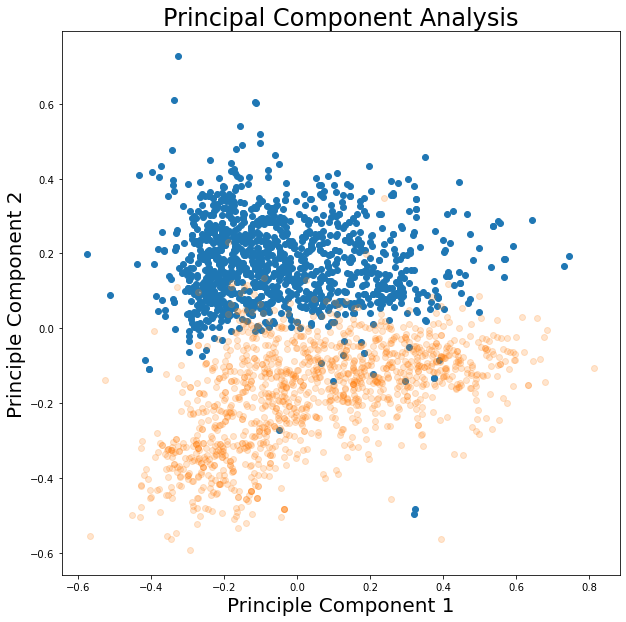

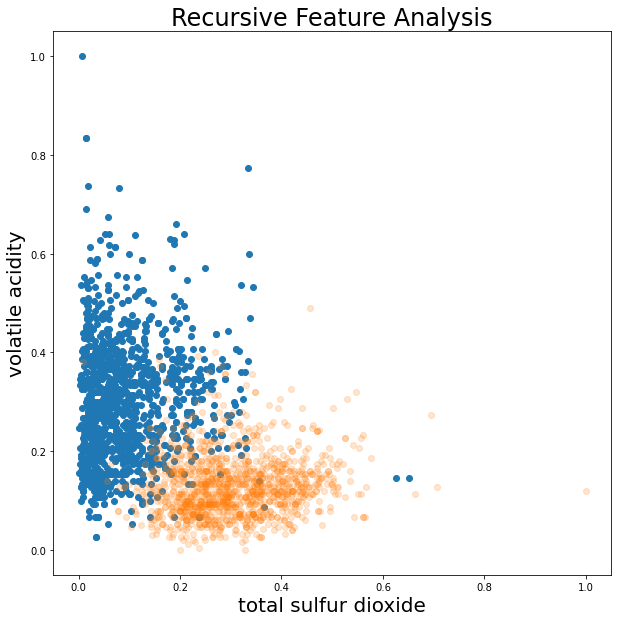

In [11]:
#Plot EVERYTHING
#sns.pairplot(po_wine, hue="type")

#Select your own downsample Seed!!
seed = 123456789
majority_downsampled = resample(df_majority, 
                             replace=False,    # sample without replacement
                             n_samples=r_size, # to match minority class
                             random_state=seed) # reproducible results
po_wine = pd.concat([majority_downsampled, df_minority])

#Create Data as NP Arrays
data = np.array(po_wine.drop('type', axis = 1) )
RFE1name='total sulfur dioxide'
RFE2name='volatile acidity'
RFEdata =  np.array(po_wine[[RFE1name,RFE2name]])
y = po_wine.loc[ : , po_wine.columns == 'type'] 
y=np.array(y.replace('white',1).replace('red',0) )


seed=1678573 #fix seed so you have the same split
split=0.2
#PCA standardization and rotation
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(data, y, test_size=split, random_state=seed)
X_pca_train_min = X_pca_train.min(axis=0)
X_pca_train_max = X_pca_train.max(axis=0)
X_pca_train = normalize(X_pca_train, X_pca_train_min, X_pca_train_max)
X_pca_test  = normalize(X_pca_test,  X_pca_train_min, X_pca_train_max)
# PCA transform the test and train data
pca_transformer = PCA(n_components=2) #
X_pca_train = pca_transformer.fit_transform(X_pca_train)
X_pca_test = pca_transformer.transform(X_pca_test)

#RFE selection and normalization
RFEtrain, RFEtest, y_train, y_test = train_test_split(RFEdata, y, test_size=split, random_state=seed)
RFEtrain_min = RFEtrain.min(axis=0)
RFEtrain_max = RFEtrain.max(axis=0)
RFEtrain = normalize(RFEtrain, RFEtrain_min, RFEtrain_max)
RFEtest  = normalize(RFEtest,  RFEtrain_min, RFEtrain_max)


#Collect Labels
r_train_loc=(y_train==0).T[0] # determine position of reds
w_train_loc=(y_train==1).T[0] #determine position of whites
r_test_loc=(y_test==0).T[0] # determine position of reds
w_test_loc=(y_test==1).T[0] #determine position of whites

#plot EDA
fig = plt.figure(figsize=(10,10))
class0 = X_pca_train[r_train_loc,:]
class1 = X_pca_train[w_train_loc,:]
plt.scatter(class0[:,0],class0[:,1], alpha=1)
plt.scatter(class1[:,0],class1[:,1], alpha=.2)
plt.title("Principal Component Analysis",fontsize=24)
plt.xlabel("Principle Component 1",fontsize=20)
plt.ylabel("Principle Component 2",fontsize=20)

fig = plt.figure(figsize=(10,10))
class0 = RFEtrain[r_train_loc,:]
class1 = RFEtrain[w_train_loc,:]
plt.scatter(class0[:,0],class0[:,1], alpha=1)
plt.scatter(class1[:,0],class1[:,1], alpha=.2)
plt.title("Recursive Feature Analysis",fontsize=24)
plt.xlabel(RFE1name,fontsize=20)
plt.ylabel(RFE2name,fontsize=20)

# UQ quantification in Test-Train Split

In [5]:
#Loop through the stuff to get 
rfe_prcnt=np.zeros((100,1))
pca_prcnt=np.zeros((100,1))
for i in range(100):
    print(i)
    seed = np.random.randint(1235123,9182374)
    split=0.2

    # RFE selection
    X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(RFEdata, y, test_size=split, random_state=seed)
    X_rfe_train_min = X_rfe_train.min(axis=0)
    X_rfe_train_max = X_rfe_train.max(axis=0)
    X_rfe_train = normalize(X_rfe_train, X_rfe_train_min, X_rfe_train_max)
    X_rfe_test  = normalize(X_rfe_test,  X_rfe_train_min, X_rfe_train_max)
    
    #PCA Stuff
    X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(data, y, test_size=split, random_state=seed)
    X_pca_train_min = X_pca_train.min(axis=0)
    X_pca_train_max = X_pca_train.max(axis=0)
    X_pca_train = normalize(X_pca_train, X_pca_train_min, X_pca_train_max)
    X_pca_test  = normalize(X_pca_test,  X_pca_train_min, X_pca_train_max)
    # PCA transform the test and train data
    pca_transformer = PCA(n_components=2) #
    X_pca_train = pca_transformer.fit_transform(X_pca_train)
    X_pca_test = pca_transformer.transform(X_pca_test)
    
    count=0
    for X_train,y_train, X_test, y_test in zip([X_pca_train, X_rfe_train],[y_pca_train, y_rfe_train],[X_pca_test, X_rfe_test],[y_pca_test, y_rfe_test]):

        ss = ShuffleSplit(n_splits=5, random_state=91235017)
        name='SVM'
        if (name == 'KNN'):
            clf = neighbors.KNeighborsClassifier(algorithm='ball_tree')
            grid={'n_neighbors': [11, 12, 13, 14, 15 ], 'weights': ('uniform', 'distance'),  'leaf_size': (2, 5, 10, 15)}
        if (name == 'SVM'):
            clf = svm.SVC()
            grid = {'C': [0.1, 1, 10, 100, 1000],  'kernel': ['linear']}
        if (name == 'DT'):
            clf = tree.DecisionTreeClassifier(random_state=7340984)
            grid = {'criterion':['gini','entropy'],
                    'splitter':['best','random'],
                    'max_depth': np.arange(3, 15),
                    'min_samples_split':np.arange(3, 15)}
        if (name == 'MLP'):
            clf = MLPClassifier(max_iter = 2000, early_stopping=True, n_iter_no_change=100, learning_rate_init=0.01, solver='adam')
            grid = {
                'hidden_layer_sizes': [(20,3), (20,6), (20,9),   # 20 Neurons
                                       (50,3), (50,6), (50,9),   # 50 Neurons
                                      ],
                'activation' : ('logistic', 'tanh', 'relu'),
            }

            
        
        grid_clf = GridSearchCV(clf, param_grid=grid,  n_jobs=-1, cv=ss)
        grid_clf.fit(X_train, y_train.ravel())
        best_clf = grid_clf.best_estimator_
        #print(best_clf.get_params(True))
        p_test = best_clf.predict(X_test)

        if (count): #rfe
            rfe_prcnt[i] = 1 - np.average(np.abs(p_test-y_test.ravel()))
            if (i==-4):
                make_plot(
                    data_t=X_test, 
                    y_t = y_test, 
                    best_clf=best_clf, 
                    clf_name=name, 
                    clf_flag='RFE',
                    score = np.float(rfe_prcnt[i,0]))
        else:       #pca
            pca_prcnt[i] = 1 - np.average(np.abs(p_test-y_test.ravel()))
            if (i==-4):
                make_plot(
                    data_t=X_test, 
                    y_t = y_test, 
                    best_clf=best_clf, 
                    clf_name=name, 
                    clf_flag='PCA',
                    score = np.float(pca_prcnt[i,0]))
        count=1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


# Generate Plots of Classification Distributions

pca: 0.9281718750000002 0.02985761703354564
rfe: 0.9470937500000001 0.007558431240178082


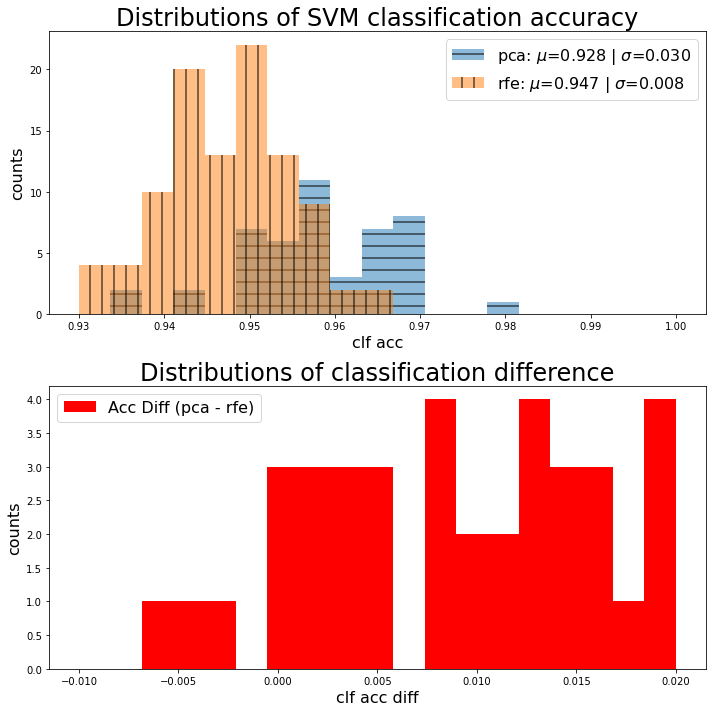

In [6]:
rfe=np.array(rfe_prcnt) 
pca=np.array(pca_prcnt)
pca_avg, pca_std = np.mean(pca), np.std(pca)
rfe_avg, rfe_std = np.mean(rfe), np.std(rfe)
print("pca:",pca_avg, pca_std)
print("rfe:",rfe_avg, rfe_std)

fsz0=24
fsz1=16
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(10,10))
# Distribution of CLF accuracy
bins=np.linspace(.93,1, 20)
axs[0].set_title("Distributions of "+ name +" classification accuracy", fontsize=fsz0)
axs[0].set_xlabel("clf acc", fontsize=fsz1)
axs[0].set_ylabel("counts", fontsize=fsz1)
axs[0].hist(pca, bins=bins,label='pca: $\mu$=%.3f | $\sigma$=%.3f'%(pca_avg,pca_std),hatch='-',alpha=.5)
axs[0].hist(rfe, bins=bins,label='rfe: $\mu$=%.3f | $\sigma$=%.3f'%(rfe_avg,rfe_std),hatch='|',alpha=.5)
axs[0].legend(fontsize=fsz1)

# Distribution of CLF accuracy difference
bins=np.linspace(-0.01,0.02, 20)
axs[1].set_title("Distributions of classification difference", fontsize=fsz0)
axs[1].hist(pca-rfe, bins=bins,label='Acc Diff (pca - rfe)',color='red')
axs[1].set_xlabel("clf acc diff", fontsize=fsz1)
axs[1].set_ylabel("counts", fontsize=fsz1)
axs[1].legend(fontsize=fsz1)